# Проверка гипотез с целью роста выручки интернет-магазина

**Цель исследования**
- Определить группу с наибольшей выручкой на основе A/B тестов

**Данные**
- hypothesis - описание гипотезы
- reach - охват пользователей по 10-балльной шкале
- impact - влияние на пользователей по 10-балльной шкале
- confidence - уверенность в гипотезе по 10-балльной шкале
- effort - затраты на проверку гипотезы по 10-балльной шкале
- transactionId - идентификатора заказа
- visitorId - идентификатор пользователя, совершившего заказ
- date - дата заказа
- revenue - выручка заказа
- group - группа A/B-теста, в котороую попал заказ

## 1. Обзор данных

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats as st
import numpy as np 
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [4]:
pd.set_option('max_colwidth', 400)
sns.set(rc={'figure.figsize':(16, 7)})

In [5]:
hypothesis = pd.read_csv('/Users/yusuf/Desktop/Programming/Projects/Data/hypothesis.csv')
orders = pd.read_csv('/Users/yusuf/Desktop/Programming/Projects/Data/orders.csv')
visitors = pd.read_csv('/Users/yusuf/Desktop/Programming/Projects/Data/visitors.csv')

In [6]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [7]:
hypothesis.duplicated().sum()

0

Данные правильного типа, дубликаты отсутствуют.

In [8]:
hypothesis.columns = map(str.lower, hypothesis.columns)
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Приведу к нужному типу дату

In [10]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')

In [11]:
orders.duplicated().sum()

0

In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


То же самое - меняю формат даты на корректный

In [13]:
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')

In [14]:
visitors.duplicated().sum()

0

## 2. Проверка на "перетекаемость" пользователей между группами

На примере заказов посмотрим, не учитывались ли покупки пользователей одной группы в покупках другой

In [15]:
print ('Количество заказов в группе А -', orders.query('group == "A"').shape[0])
print ('Количество заказов в группе B -',orders.query('group == "B"').shape[0])

Количество заказов в группе А - 557
Количество заказов в группе B - 640


In [16]:
visitorsA = orders[orders['group']=='A']['visitorId']
visitorsB = orders[orders['group']=='B']['visitorId']

In [17]:
visitors_AB = orders.loc[orders['visitorId'].isin(visitorsA)& orders['visitorId'].isin(visitorsB),'visitorId'].unique()

In [18]:
orders = orders.loc[~orders['visitorId'].isin(visitors_AB)]

In [19]:
print ('Количество заказов в группе А -', orders.query('group == "A"').shape[0])
print ('Количество заказов в группе B -',orders.query('group == "B"').shape[0])

Количество заказов в группе А - 468
Количество заказов в группе B - 548


Поставив границы уникальности покупателей по группам можно увидеть, что снизился как разрыв между количествами заказов, так и общее количество заказов

### 2.1 Применение фреймворка ICE

In [20]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

In [21]:
display(hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False))

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наиболее приоритетными гипотезами являются 8, 0 и 7

### 2.2 Применение фреймворка RICE

In [22]:
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

In [23]:
display(hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False))

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее приоритетными гипотезами являются 7, 2, 0 и 6

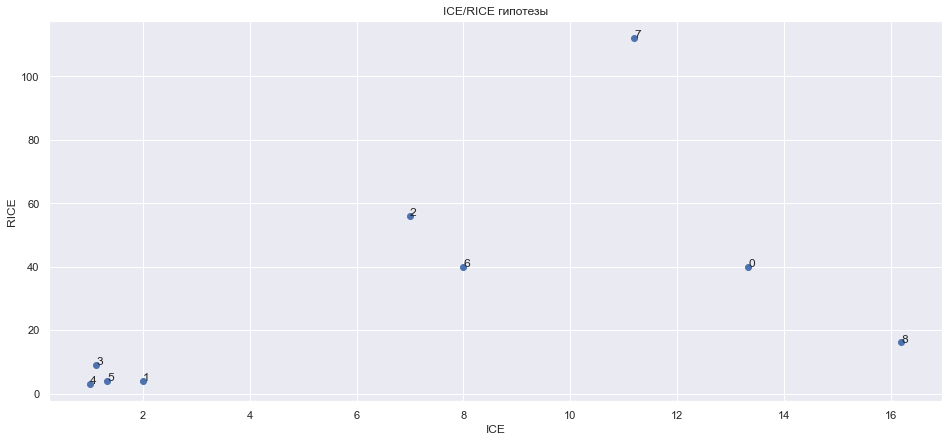

In [24]:
y = hypothesis['rice']
z = hypothesis['ice']
n = hypothesis.index

fig, ax = plt.subplots(figsize=(16, 7))
ax.scatter(z, y)

for i, txt in enumerate(n):
     ax.annotate(txt, (z[i], y[i]))

plt.title('ICE/RICE гипотезы')
plt.xlabel('ICE')
plt.ylabel('RICE')
plt.show()

**Промежуточный вывод**
+ После применения RICE, гипотеза №7 выбилась в лидеры, так как она имеет наибольшее значение Reach. По той же причине гипотеза №2 на второй позиции.
+ Гипотеза №8 вылетела, так как её показатель Reach равен единице.
+ В списке лидеров появилась гипотеза №6. Несмотря на то, что у неё низкий показатель влияния, она имеет средний показатель охвата, низкую стоимость и высокую уверенность.

## 3. Анализ A/B-теста

### 3.1 Построение графика кумулятивной выручки

In [25]:
dates_groups = orders[['date','group']].drop_duplicates()

In [26]:
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(orders["date"] <= x["date"], orders["group"] == x["group"])
    ].agg(
        {"date": "max", "group": "max", "revenue": "sum", "transactionId": "nunique"}
    ),
    axis=1,
).sort_values(by=["date", "group"])

In [27]:
orders_aggregated.rename(columns={'transactionId':'orders'}, inplace=True)

In [28]:
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(visitors["date"] <= x["date"], visitors["group"] == x["group"])
    ].agg({"date": "max", "group": "max", "visitors": "sum"}),
    axis=1,
).sort_values(by=["date", "group"])

In [29]:
cumulative_data = orders_aggregated.merge(visitors_aggregated, on=['date','group'])

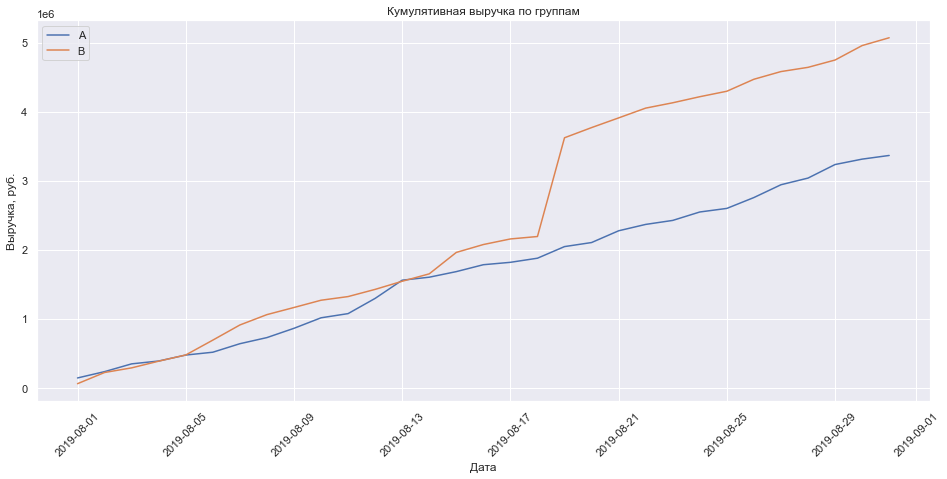

In [30]:
cumulative_a = cumulative_data.loc[cumulative_data['group'] == 'A',['date','revenue','orders','visitors']]
cumulative_b = cumulative_data.loc[cumulative_data['group'] == 'B',['date','revenue','orders','visitors']]

plt.figure()
plt.plot(cumulative_a['date'], cumulative_a['revenue'], label='A')
plt.plot(cumulative_b['date'], cumulative_b['revenue'], label='B')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Выручка, руб.')
plt.title('Кумулятивная выручка по группам')
plt.legend();

Рост выручки в группе А происходит равномерно, в то время как у группы B происходит скачок выручки 17 августа

### 3.2 Построение графика кумулятивного среднего чека

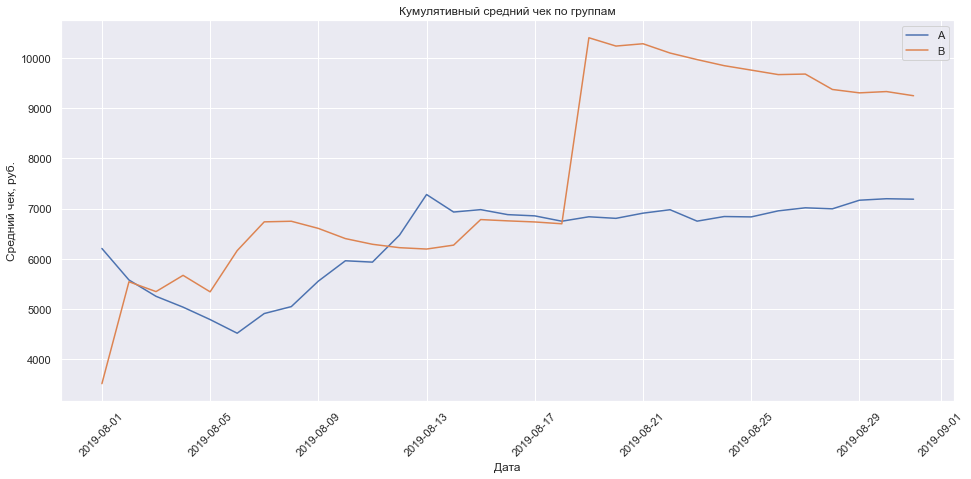

In [31]:
plt.figure()
plt.plot(cumulative_a['date'], cumulative_a['revenue'] / cumulative_a['orders'], label='A')
plt.plot(cumulative_b['date'], cumulative_b['revenue'] / cumulative_b['orders'], label='B')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Средний чек, руб.')
plt.title('Кумулятивный средний чек по группам')
plt.legend();

Средний чек группы А растет до 13 августа, после чего становится ровным. У группы B заметен тот же самый скачок

### 3.3 Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

In [32]:
merged_cumulative = cumulative_a.merge(cumulative_b, on=['date'],suffixes=('_a', '_b'))

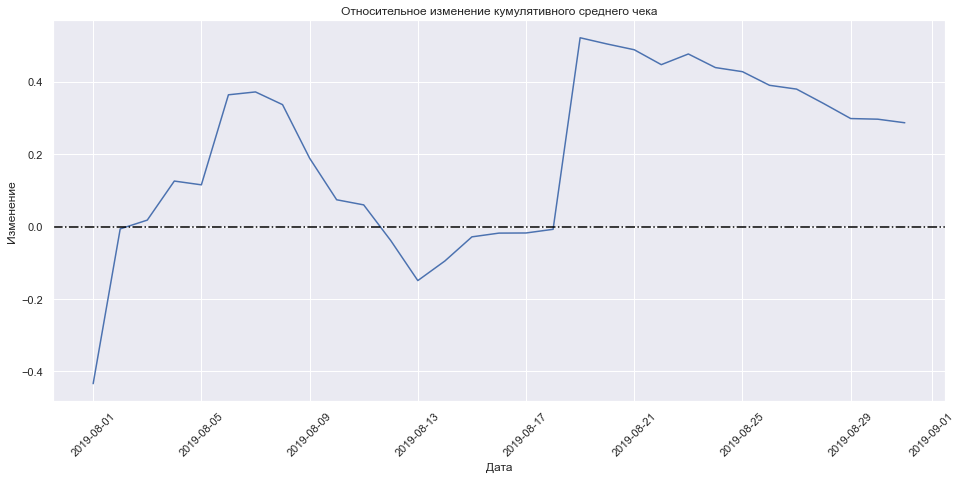

In [33]:
plt.figure()
plt.plot(
    merged_cumulative['date'],
    (merged_cumulative['revenue_b'] / merged_cumulative['orders_b']) / (merged_cumulative['revenue_a'] / merged_cumulative['orders_a']) -1
)
plt.xticks(rotation=45)
plt.title('Относительное изменение кумулятивного среднего чека')
plt.xlabel('Дата')
plt.ylabel('Изменение')
plt.axhline(y=0, color='black', linestyle='-.');

Рост чека в первую неделю августа стал сюрпизом, в отличие от рывка 17 августа

### 3.3 Построение графика кумулятивной конверсии по группам

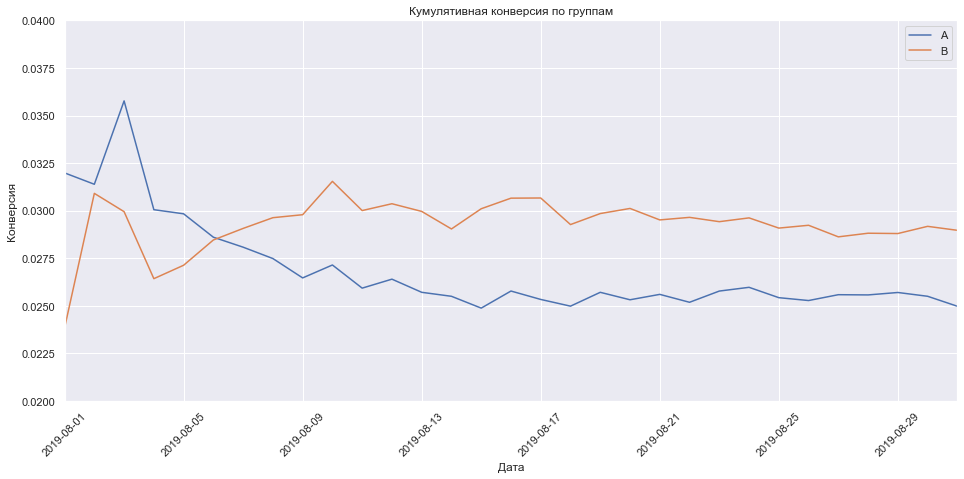

In [34]:
plt.figure()
plt.plot(cumulative_a['date'], cumulative_a['orders'] / cumulative_a['visitors'], label='A')
plt.plot(cumulative_b['date'], cumulative_b['orders'] / cumulative_b['visitors'], label='B')
plt.xticks(rotation=45)
plt.title('Кумулятивная конверсия по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.axis(xmin=cumulative_a['date'].min(), xmax=cumulative_a['date'].max(), ymin=.020, ymax=0.04)
plt.legend();

Группа B лидирует практически с первых дней

### 3.4 Построение графика относительного изменения кумулятивной конверсии группы B к группе A

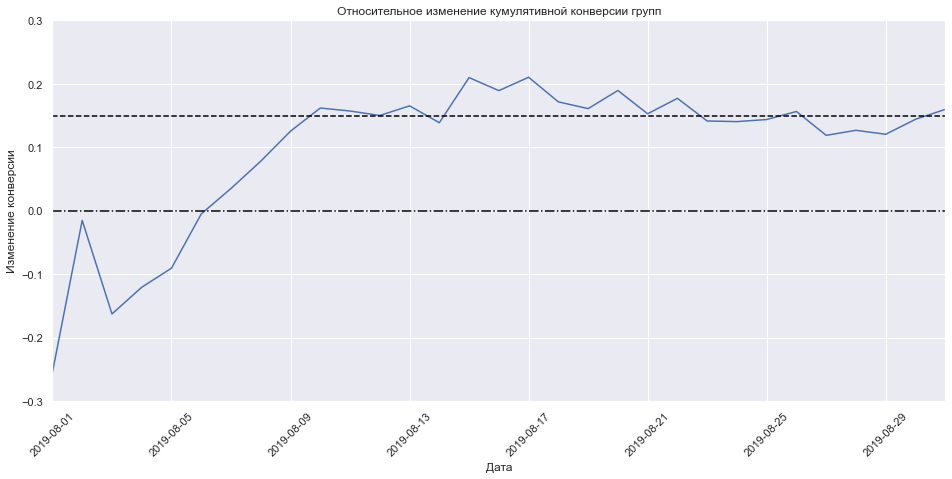

In [35]:
plt.figure()
plt.plot(
    merged_cumulative['date'],
    (merged_cumulative['orders_b'] / merged_cumulative['visitors_b']) / (merged_cumulative['orders_a'] / merged_cumulative['visitors_a']) -1
)
plt.xticks(rotation=45)
plt.title('Относительное изменение кумулятивной конверсии групп')
plt.xlabel('Дата')
plt.ylabel('Изменение конверсии')
plt.axis(xmin=merged_cumulative['date'].min(), xmax=merged_cumulative['date'].max(), ymin=-0.30, ymax=0.3)
plt.axhline(y=0, color='black', linestyle='-.')
plt.axhline(y=0.15, color='black', linestyle='--');

Группа B стабильно прибыльнее

### 3.5 Построение точечного графика количества заказов по пользователям

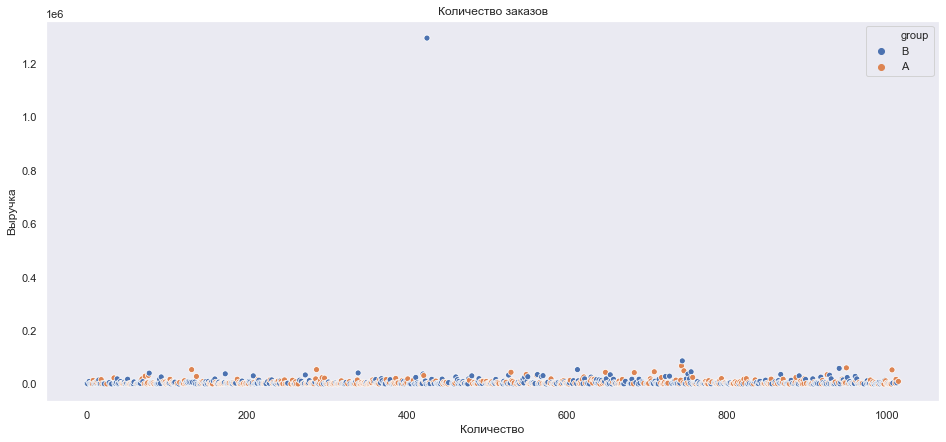

In [36]:
x_values = pd.Series(range(0,orders['revenue'].count())) 

plt.figure()
sns.scatterplot(x=x_values, y="revenue", hue="group",
                     data=orders)
plt.xlabel('Количество')
plt.ylabel('Выручка')
plt.grid()
plt.title('Количество заказов');

- Один крупный заказ группы B

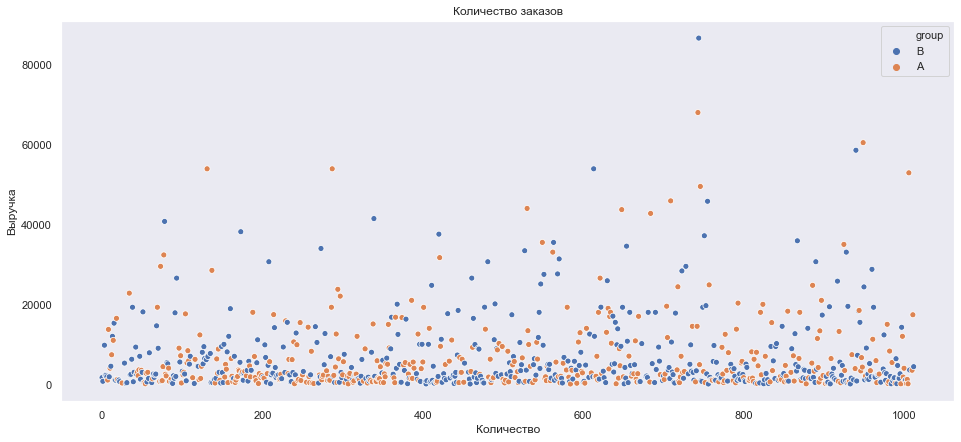

In [37]:
orders_clean = orders.query('revenue<200000')
x_values = pd.Series(range(0,orders_clean['revenue'].count())) 
plt.figure()
sns.scatterplot(x=x_values, y="revenue", hue="group",
                     data=orders_clean)
plt.grid()
plt.xlabel('Количество')
plt.ylabel('Выручка')
plt.title('Количество заказов');

### 3.6 Расчет 95-го и 99-го перцентилей количества заказов на пользователя.

In [38]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Можно попробовать избавиться от выбросов, убрав всё, что выше 99-го процентиля

In [39]:
per_99 = np.percentile(orders['revenue'], [99])[0]
orders_clean = orders.query('revenue<= @per_99')

### 3.7 Построение точечного графика стоимости заказов.

In [40]:
orders_by_users = (
    orders.groupby("visitorId")["revenue"]
    .count()
    .reset_index()
    .rename(columns={"revenue": "orders"})
)

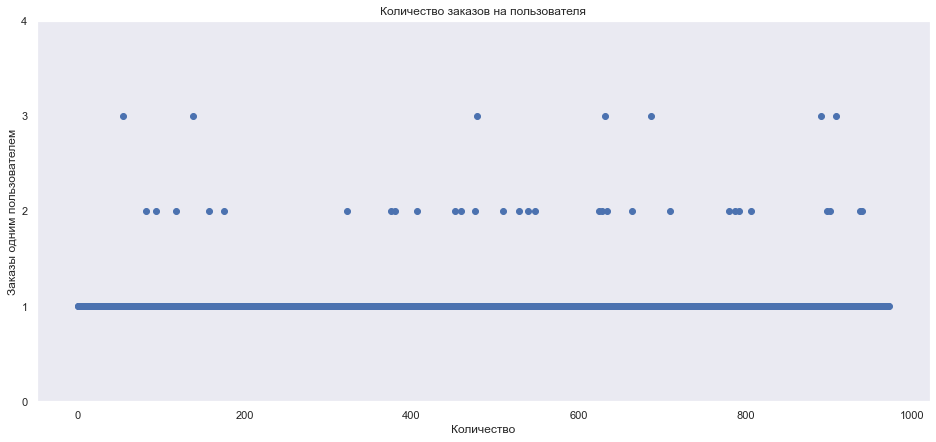

In [41]:
x_values = pd.Series(range(0,orders_by_users['orders'].count())) 
plt.figure()
plt.scatter(data=orders_by_users, x=x_values, y='orders') 
plt.grid()
plt.title('Количество заказов на пользователя')
plt.xlabel('Количество')
plt.ylabel('Заказы одним пользователем')
plt.yticks([0,1,2,3,4]);

Пожалуй уберем все, что больше 3 заказов

### 3.8 Расчет 95-го и 99-го перцентилей стоимости заказов

In [42]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[1. 2.]


Пожалуй уберем все, что больше 3 заказов

In [43]:
per_99 = np.percentile(orders_by_users['orders'], [99])[0]
orders_by_users_clean = orders_by_users.query('orders<= @per_99')

In [44]:
orders_clean = orders_clean.loc[orders_clean['visitorId'].isin(orders_by_users_clean['visitorId'])]

**Вывод**
+ Данные прошли первичную фильтрацию, была решена проблема перетекания пользователей по группам.
+ Группа В кажется более предпочтительной по своей выручке, даже после очистки аномального выброса с крупным чеком.

## 4. Проверка гипотез

### 4. 1 Расчет статистической значимости различий в конверсии между группами по «сырым» данным

**Гипотезы (уровень значимости 5%)**
+ Н0: Конверсия группы А имеет статистически незначимые различия с конверсией группы B
+ Н1: Конверсия группы А не имеет статистически незначимых различий с конверсией группы B

In [45]:
orders_by_usersA = orders[orders['group']=='A'].groupby('visitorId')['transactionId'].nunique().reset_index()
orders_by_usersA.columns=['visitorsId','orders']

orders_by_usersB = orders[orders['group']=='B'].groupby('visitorId')['transactionId'].nunique().reset_index()
orders_by_usersB.columns=['visitorsId','orders']

In [46]:
freeloadersA = pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() - len(orders_by_usersA['orders'])), name='orders')
freeloadersB = pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visitors'].sum() - len(orders_by_usersB['orders'])), name='orders')

In [47]:
sampleA = pd.concat([orders_by_usersA['orders'], freeloadersA])
sampleB = pd.concat([orders_by_usersB['orders'], freeloadersB])

In [48]:
print('p_value: {:.5f}'.format(st.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]))
print('Средняя конверсия группы А: {:.1%}'.format(sampleA.mean()))
print('Средняя конверсия группы B: {:.1%}'.format(sampleB.mean()))

p_value: 0.01102
Средняя конверсия группы А: 2.5%
Средняя конверсия группы B: 2.9%


Нулевая гипотеза о равенстве средних конверсий отвергается на 5% уровне.

### 4.2 Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным

**Гипотезы (уровень значимости 5%)**
+ Н0: Средний чек группы А имеет статистически незначимые различия со средним чеком группы B
+ Н1: Средний чек группы А не имеет статистически незначимых различий со средним чеком группы B

In [49]:
print(
    "p_value: {:.5f}".format(
        st.mannwhitneyu(
            orders[orders["group"] == "A"]["revenue"],
            orders[orders["group"] == "B"]["revenue"],
            alternative="two-sided",
        )[1]
    )
)

print('Средний чек группы А: {:.2f}'.format(orders[orders['group']=='A']['revenue'].mean()))
print('Средний чек группы B: {:.2f}'.format(orders[orders['group']=='B']['revenue'].mean()))

p_value: 0.82949
Средний чек группы А: 7189.44
Средний чек группы B: 9249.95


Нулевая гипотеза о равенстве средних чеков не отвергается на 5% уровне.

### 4.3 Расчет статистической значимости различий в конверсии между группами по «очищенным» данным

**Гипотезы (уровень значимости 5%)**
+ Н0: Конверсия группы А имеет статистически незначимые различия с конверсией группы B
+ Н1: Конверсия группы А не имеет статистически незначимых различий с конверсией группы B

In [51]:
orders_by_usersA = orders_clean[orders_clean['group']=='A'].groupby('visitorId')['transactionId'].nunique().reset_index()
orders_by_usersA.columns=['visitorsId','orders']

orders_by_usersB = orders_clean[orders_clean['group']=='B'].groupby('visitorId')['transactionId'].nunique().reset_index()
orders_by_usersB.columns=['visitorsId','orders']

In [52]:
freeloadersA = pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() - len(orders_by_usersA['orders'])), name='orders')
freeloadersB = pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visitors'].sum() - len(orders_by_usersB['orders'])), name='orders')

In [53]:
sampleA = pd.concat([orders_by_usersA['orders'], freeloadersA])
sampleB = pd.concat([orders_by_usersB['orders'], freeloadersB])

In [54]:
print('p_value: {:.5f}'.format(st.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]))
print('Средняя конверсия (очищенная) группы А: {:.1%}'.format(sampleA.mean()))
print('Средняя конверсия (очищенная) группы B: {:.1%}'.format(sampleB.mean()))

p_value: 0.00695
Средняя конверсия (очищенная) группы А: 2.4%
Средняя конверсия (очищенная) группы B: 2.8%


Нулевая гипотеза о равенстве вновь отвергается

### 4.4 Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным

**Гипотезы (уровень значимости 5%)**
+ Н0: Средний чек группы А имеет статистически незначимые различия со средним чеком группы B
+ Н1: Средний чек группы А не имеет статистически незначимых различий со средним чеком группы B

In [55]:
print(
    "p_value: {:.5f}".format(
        st.mannwhitneyu(
            orders_clean[orders_clean["group"] == "A"]["revenue"],
            orders_clean[orders_clean["group"] == "B"]["revenue"],
            alternative="two-sided",
        )[1]
    )
)

print('Средний чек (очищенный) группы А: {:.2f}'.format(orders_clean[orders_clean['group']=='A']['revenue'].mean()))
print('Средний чек (очищенный) группы B: {:.2f}'.format(orders_clean[orders_clean['group']=='B']['revenue'].mean()))

p_value: 0.78770
Средний чек (очищенный) группы А: 6487.02
Средний чек (очищенный) группы B: 6277.27


Нулевая гипотеза о равнестве средних чеков вновь не отвергается. По очищенным данным лучше видно почему - средний чек очень близок между группами

## 5. Общий вывод

- **Краткий обзор проведенной работы:** В рамках работы группы были проверены на отсутствие перетекаемости между ними, были выделены ключевые гипотезы по фреймфоркам ICE/RICE. В рамках A/B теста были построены графики кумулятивной выручки, среднего чека и конверсии. Были проверены гипотезы о статистической значимости различий между группами.
- **Главные выводы:** Далее проводить тест необходимость отсутствует, несмотря на очистку данных группа B показала более позитивные результаты - выручка в данной группе выше, несмотря на близкий средний чек. В результате анализа с очисткой данных была выявлена статистическая значимость средней конверсии между группами, с вероятностью ошибки 5%. При этом средний чек по группам оказался равен, с вероятностью ошибки 5%. Применение фреймворков показало, что в первую очередь компании необходимо добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок и добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа